# Climate factors influencing the seasonal variation in mortality in Brazil

I was able to accurately pinpoint the [seasonal variation in mortality in Brazil](link-here) and its variation across the country. I pointed out the benefits and problems with each seasonality metric and why the metric I proposed, called EDi, is appropriate. However, we are still left with a more difficult question: what drives that seasonality? Most researchers look at climate and socioeconomic factors to answer this question. While we firmly believe that socioeconomic factors play a role, the literature is still unclear on how exactly, and it is hard to measure things like housing quality, diet, and other metrics. Climate measures, on the other hand, are much more tangible.

With data from [INMET - Brazil's National Institute of Meteorology](https://portal.inmet.gov.br/), we analyze the relationship between various climate variables and mortality in Brazil, looking for hints of the driving factors of the seasonal variation in mortality. Historical data from [INMET's automathic stations](https://portal.inmet.gov.br/dadoshistoricos) suits large-scale analysis. As we can see in the [glossary](https://portal.inmet.gov.br/glossario/glossario), there are many weather measures available, but only the main ones, such as Temperature, Humidity, and Precipitation, are present in most cities. Yet, many small towns have too much missing data on those main weather measures, so we only looked at the state capitals. To process the data from the cities, we used the [catalog of automatic stations](https://portal.inmet.gov.br/paginas/catalogoaut).

Note: I'm using an integrated Colab + Google Drive environment for this project, but this could be done similarly with a local Jupyter lab, Jupyter notebook, or even just a regular Python compiler.

# Importing Libraries and Defining Capitals, Stations, Weather Variables, and ICD-10 Causes of Death

In [1]:
!pip install numpy==1.23.5
!pip install pandas==2.1.1
!pip install xlrd==2.0.1
!pip install matplotlib==3.7.1
!pip install seaborn==0.13.0
!pip install ipython==7.34.0
!pip install epiweeks==2.2.0
!pip install regex==2023.6.3
!pip install scipy==1.11.4
!pip install sklearn==1.2.2
!pip install shap==0.45.1

ERROR: Could not find a version that satisfies the requirement sklearn==1.2.2 (from versions: 0.0, 0.0.post1, 0.0.post2, 0.0.post4, 0.0.post5, 0.0.post7, 0.0.post9, 0.0.post10, 0.0.post11, 0.0.post12)
ERROR: No matching distribution found for sklearn==1.2.2


In [2]:
#importing libraries

#ds libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import re
import os

#processing
from sklearn.impute import KNNImputer

#print
BOLD = '\033[1m'
END = '\033[0m'

#ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive/')
path = '/content/drive/My Drive/seasonal_mortality_hub/data/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
#states and capitals

states = ['RS', 'SC', 'PR', 'SP', 'RJ', 'MS', 'ES', 'MG', 'GO', 'DF', 'MT', 'BA',
          'SE', 'TO', 'AC', 'AL', 'RO', 'PE', 'PB', 'RN', 'PI', 'CE', 'AM', 'MA', 'PA', 'AP', 'RR']
capital_dict = {
 'RS': 'Porto Alegre - RS',
 'SC': 'Florianópolis - SC',
 'PR': 'Curitiba - PR',
 'SP': 'São Paulo - SP',
 'RJ': 'Rio de Janeiro - RJ',
 'MS': 'Campo Grande - MS',
 'ES': 'Vitória - ES',
 'MG': 'Belo Horizonte - MG',
 'GO': 'Goiânia - GO',
 'DF': 'Brasília - DF',
 'MT': 'Cuiabá - MT',
 'BA': 'Salvador - BA',
 'SE': 'Aracaju - SE',
 'TO': 'Palmas - TO',
 'AC': 'Rio Branco - AC',
 'AL': 'Maceió - AL',
 'RO': 'Porto Velho - RO',
 'PE': 'Recife - PE',
 'PB': 'João Pessoa - PB',
 'RN': 'Natal - RN',
 'PI': 'Teresina - PI',
 'CE': 'Fortaleza - CE',
 'AM': 'Manaus - AM',
 'MA': 'São Luís - MA',
 'PA': 'Belém - PA',
 'AP': 'Macapá - AP',
 'RR': 'Boa Vista - RR'
}
capitals = list(reversed(capital_dict.values()))

In [4]:
# ICD dictionary
icd_dict = {
  'A00-B99':  'Certain infectious and parasitic diseases',
  'C00-D49':  'Neoplasms',
  'D50-D89':  'Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism',
  'E00-E89':  'Endocrine, nutritional and metabolic diseases',
  'F01-F99':  'Mental, Behavioral and Neurodevelopmental disorders',
  'G00-G99':  'Diseases of the nervous system',
  'H00-H59':  'Diseases of the eye and adnexa',
  'H60-H95':  'Diseases of the ear and mastoid process',
  'I00-I99':  'Diseases of the circulatory system',
  'J00-J99':  'Diseases of the respiratory system',
  'K00-K95':  'Diseases of the digestive system',
  'L00-L99':  'Diseases of the skin and subcutaneous tissue',
  'M00-M99':  'Diseases of the musculoskeletal system and connective tissue',
  'N00-N99':  'Diseases of the genitourinary system',
  'O00-O9A':  'Pregnancy, childbirth and the puerperium',
  'P00-P96':  'Certain conditions originating in the perinatal period',
  'Q00-Q99':  'Congenital malformations, deformations and chromosomal abnormalities',
  'R00-R99':  'Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified',
  'S00-T88':  'Injury, poisoning and certain other consequences of external causes',
  'U00-U85':  'Codes for special purposes',
  'V00-Y99':  'External causes of morbidity',
  'Z00-Z99':  'Factors influencing health status and contact with health services'
}

# Top-10 causes of death
top_causes = ['Diseases of the circulatory system',
              'Neoplasms',
              'External causes of morbidity',
              'Diseases of the respiratory system',
              'Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified',
              'Endocrine, nutritional and metabolic diseases',
              'Diseases of the digestive system',
              'Certain infectious and parasitic diseases',
              'Certain conditions originating in the perinatal period',
              'Diseases of the genitourinary system']

# Weather aggregation dictionary
weather_aggregation = {'air_temperature':'mean',
                       'atmospheric_pressure':'mean',
                       'dew_point_temperature':'mean',
                       'global_radiation':'mean',
                       'max_air_temperature':'max',
                       'max_atmospheric_pressure':'max',
                       'max_dew_point_temperature':'max',
                       'max_relative_humidity':'max',
                       'max_wind_gust':'max',
                       'min_air_temperature':'min',
                       'min_atmospheric_pressure':'min',
                       'min_dew_point_temperature':'min',
                       'min_relative_humidity':'min',
                       'precipitation':'mean',
                       'relative_humidity':'mean',
                       'wind_direction':'mean',
                       'wind_speed':'mean'}

In [5]:
#getting climate data
climate_df = pd.read_csv(f'{path}inmet/inmet_data_aggregated_imputed.csv', index_col=[0,1], header=[0,1])

# Correlations

After thorough consideration, taking into consideration that we grouped the Brazilian states into three major groups according to their seasonality of mortality, we decided to focus our analysis on three cities, each one the major city belonging to each group:

- For the northern group, with small seasonality, an early-autumn mortality peak, and a late spring mortality trough, the city of Fortaleza - CE.

- For the central group, with small seasonality, an early-winter mortality peak, and a mid-spring mortality trough, the city of Rio de Janeiro - RJ.

- For the southern group, with large seasonality, an early-winter peak, and a late-summer trough, the city of São Paulo - SP.

Those are very populated major cities, São Paulo being the largest city of Brazil (in terms of population), Rio de Janeiro the second, and Fortaleza the fourth.

For each of those cities, we check and investigate the results of the correlation between weather variables, between mortality Time Series, and between weather variables and mortality TS. Considering that a lot of literature points out that some causes of death experience a more immediate effect of mortality and others are more delayed, we also checked the maximum lagged correlation (from a lag of 0 days up to a lag of 30 days).

Examining the results, we see in São Paulo and Rio de Janeiro a correlation between Diseases of the circulatory and respiratory systems, while in Fortaleza, it is not present. There is a lot of correlation between weather variables, as is expected because many variables are very related, such as Maximum Temperature and Minimum Temperature, and even between some that we did not expect and do not seem directly related at first, like Temperature and Atmospheric Pressure.

The variable we are more interested in is Dew Point Temperature (Td), as it is known for its particular relation to human comfort. It depends on Dry Bulb Temperature (T) and Relative Humidity (RH), as we can see in the approximation:

$$ Td = T - \frac{100-RH}{5} $$

Note that typically, when we refer to Temperature alone, we are talking about Dry Bulb Temperature; when we speak about Dew Point Temperature, we say it fully.

Looking at the correlations, we see that in São Paulo and Rio de Janeiro, Dew Point Temperature is more related to Air Temperature (Dry Bulb Temperature). At the same time, in Fortaleza, it is more associated with Relative Humidity, and we believe that happens because of the diverse climates between the three cities. In São Paulo, there is a lot of temperature variation throughout the year; in Rio de Janeiro, it is less but still substantial, while in Fortaleza, the most considerable variation is due to Humidity, with the weather being marked by a "dry" and humid weather. We say "dry" in quotes because although it is called a dry season, it is still very humid so that a better description would be a marked distinction between a humid and a very humid season.

It is also worth mentioning that Pearson and Spearman correlation values are similar and better than Kendall's. Therefore, I use Pearson instead of Spearman by Occam's razor, as Pearson (linear relationship) is simpler than Spearman (monotonic relationship).

In [6]:
correlation_method = 'pearson'

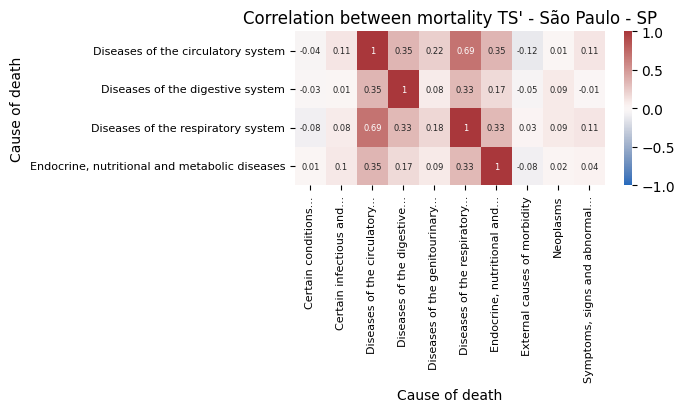

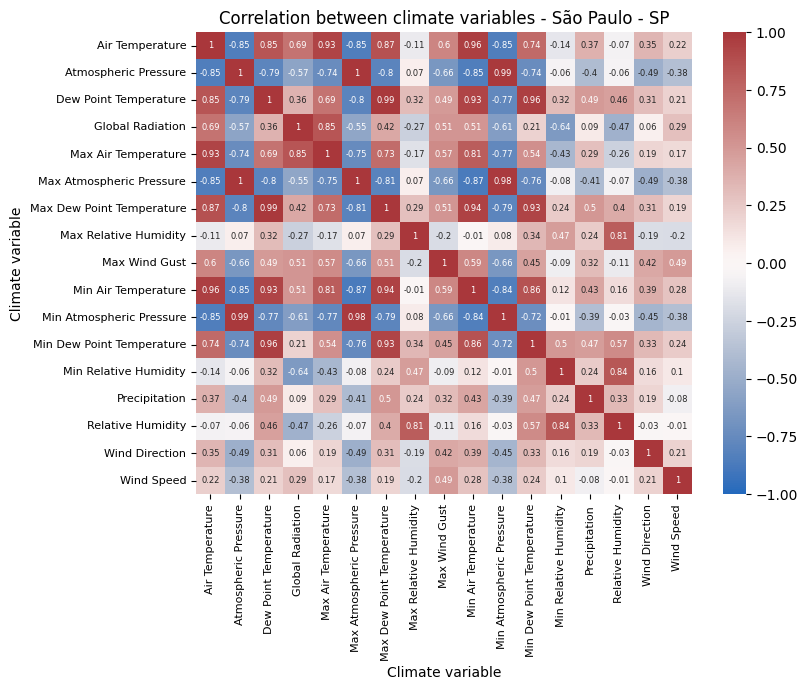

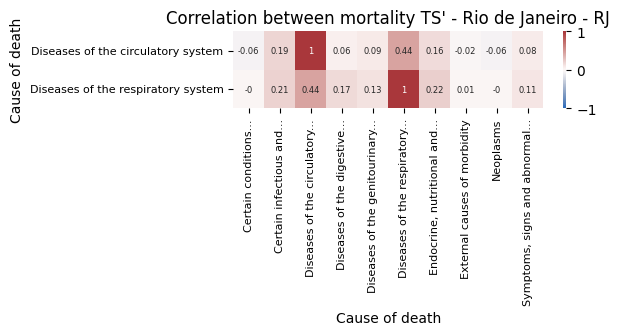

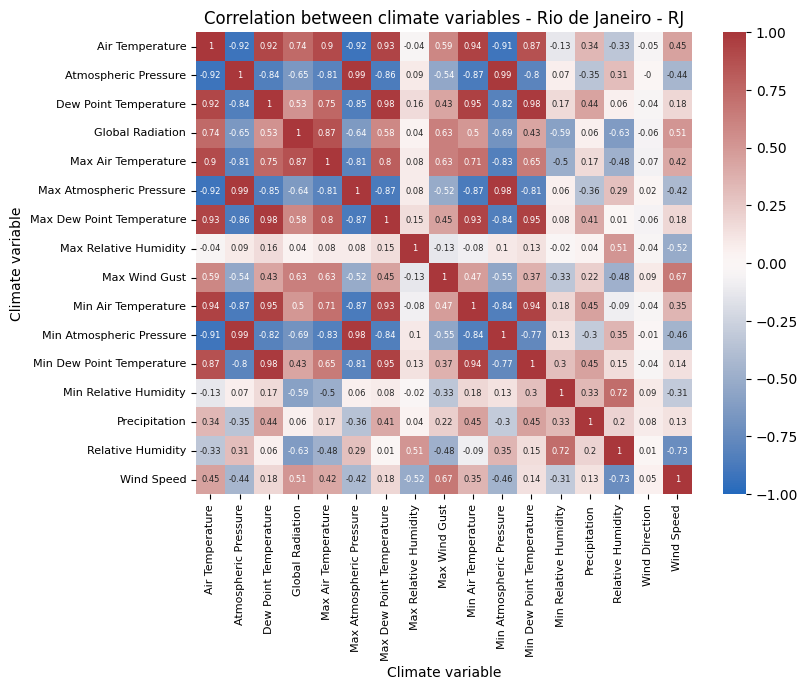

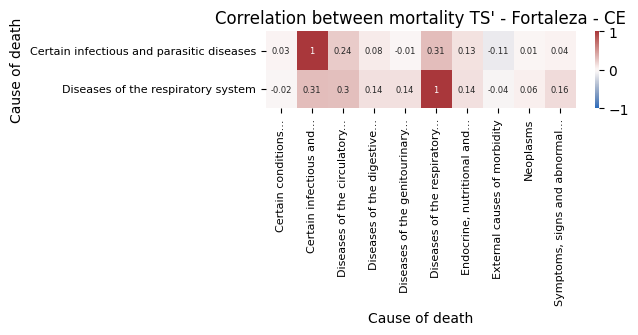

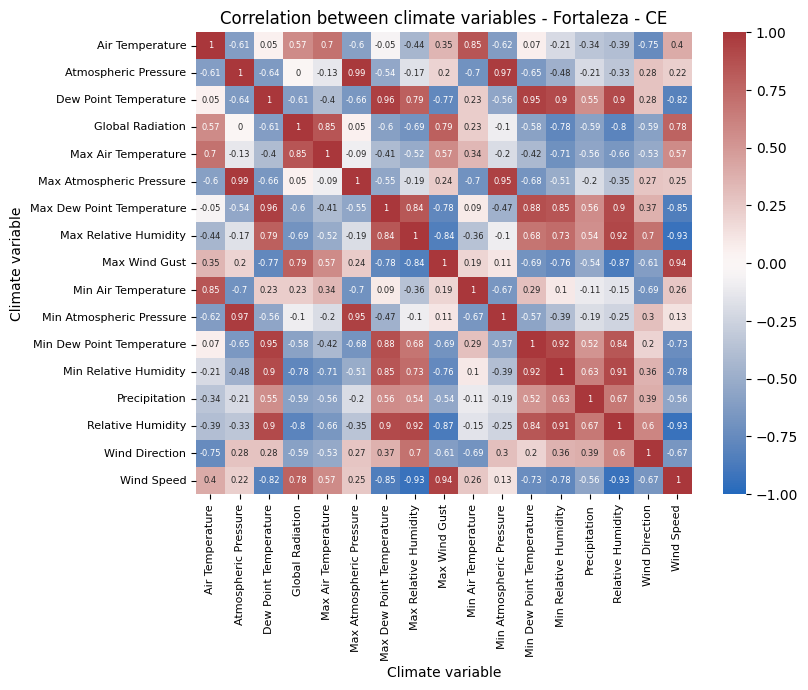

In [7]:
death_column = 'DEATHS_STANDARDIZED_BR'
weather_variables = ['air_temperature', 'atmospheric_pressure', 'dew_point_temperature',
                     'global_radiation', 'max_air_temperature', 'max_atmospheric_pressure',
                     'max_dew_point_temperature', 'max_relative_humidity', 'max_wind_gust',
                     'min_air_temperature', 'min_atmospheric_pressure',
                     'min_dew_point_temperature', 'min_relative_humidity', 'precipitation',
                     'relative_humidity', 'wind_direction', 'wind_speed']
weather_names = [x.replace('_', ' ').title() for x in weather_variables]
weather_dict = {x:y for (x,y) in zip(weather_variables, weather_names)}
corr_cv=0.3
for state, i in zip(['SP', 'RJ', 'CE'], range(3)):

  # Get climate data
  climate_data = climate_df.reset_index().set_index('time')
  climate_data = climate_data[[(state, x) for x in weather_variables]]
  climate_data.index = pd.to_datetime(climate_data.index)
  climate_data.columns = climate_data.columns.get_level_values(1)
  climate_data = climate_data.resample('D').agg(weather_aggregation)

  # Get ICD-code group from ICD-code
  icd_dict_keys = list(icd_dict.keys())
  divide_codes = [x.split('-') for x in icd_dict_keys]
  def f(x):
    for i in range(len(divide_codes)):
      if divide_codes[i][0]<=x<=divide_codes[i][1]:
        return icd_dict[icd_dict_keys[i]]

  # Get mortality data
  mortality_data = pd.read_csv(f'{path}sim/capitals_standardized/{state}_standardized_1996_2022.csv')
  mortality_data.DT = pd.to_datetime(mortality_data.DT)
  mortality_data = mortality_data[(mortality_data.DT.dt.year>=2013)&(mortality_data.DT.dt.year<=2018)]
  mortality_data.DT = mortality_data.DT.dt.strftime('%m-%d')
  mortality_data = mortality_data[mortality_data.DT!='02-29'] #remove february 29th
  mortality_data.DT = pd.to_datetime('2024-'+mortality_data.DT)
  mortality_data.CAUSE = mortality_data.CAUSE.apply(lambda x: f(x))
  mortality_data = mortality_data[mortality_data.CAUSE.isin(top_causes)]
  mortality_data = mortality_data[['DT', 'CAUSE', death_column]].groupby(['CAUSE', 'DT']).sum().reset_index()
  mortality_data = mortality_data.pivot(index='DT', columns='CAUSE', values=death_column)
  causes_of_death = [' '.join(x[:x.rfind(' ', 0, 60)].split()) + '...' if len(x) > 60 else x for x in mortality_data.columns]
  causes_of_death_dict = {x:y for (x, y) in zip(mortality_data.columns, causes_of_death)}
  causes_of_death_simplified = [' '.join(x[:x.rfind(' ', 0, 30)].split()) + '...' if len(x) > 30 else x for x in mortality_data.columns]
  causes_of_death_simplified_dict = {x:y for (x, y) in zip(mortality_data.columns, causes_of_death_simplified)}

  # Merge data
  data = mortality_data.merge(climate_data, left_index=True, right_index=True)
  data = data.rename(columns={death_column:'deaths'})

  def corr_plot(data, title, x_label, x_ticks_dict, y_label, y_ticks_dict):
    x_ticks = data.columns.map(x_ticks_dict)
    y_ticks = data.index.map(y_ticks_dict)
    fig, ax_ij = plt.subplots(figsize=(min(0.5*len(x_ticks),8), min(0.5*len(y_ticks),6)))
    sns.heatmap(data, annot=True, annot_kws={'size': 6},
                vmin=-1, vmax=1, cmap='vlag', ax=ax_ij)
    ax_ij.set_title(f'{title} - {capital_dict[state]}', fontsize=12)
    ax_ij.set_xlabel(x_label, fontsize=10)
    ax_ij.set_xticks(np.arange(0.5, len(x_ticks)), x_ticks, rotation=90, fontsize=8)
    ax_ij.set_ylabel(y_label, fontsize=10)
    ax_ij.set_yticks(np.arange(0.5, len(y_ticks)), y_ticks, fontsize=8)
    plt.show()

  # Correlation between mortality TS'
  mortality_data_corr = mortality_data.corr(correlation_method).round(2)
  mortality_data_corr = mortality_data_corr[((mortality_data_corr.abs()>corr_cv)&(mortality_data_corr!=1)).any(axis=1)]
  corr_plot(mortality_data_corr, "Correlation between mortality TS'",
            'Cause of death', causes_of_death_simplified_dict,
            'Cause of death', causes_of_death_dict)

  # Correlation between weather variables
  climate_data_corr = climate_data.corr(correlation_method).round(2)
  climate_data_corr = climate_data_corr[((climate_data_corr.abs()>corr_cv)&(climate_data_corr!=1)).any(axis=1)]
  corr_plot(climate_data_corr, 'Correlation between climate variables',
            'Climate variable', weather_dict,
            'Climate variable', weather_dict)

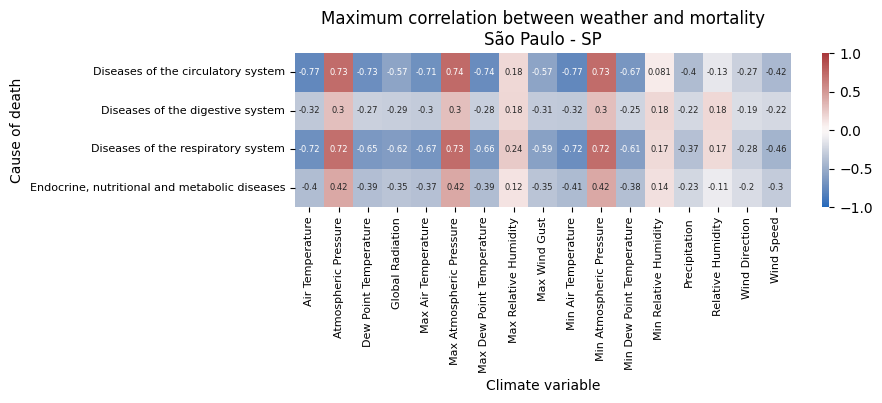

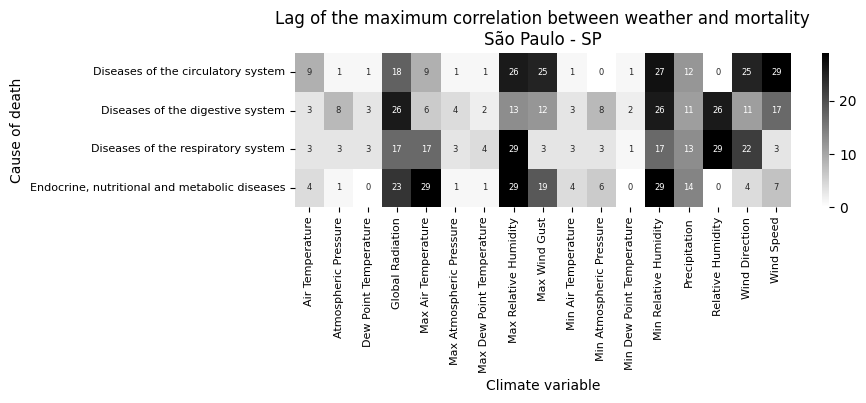

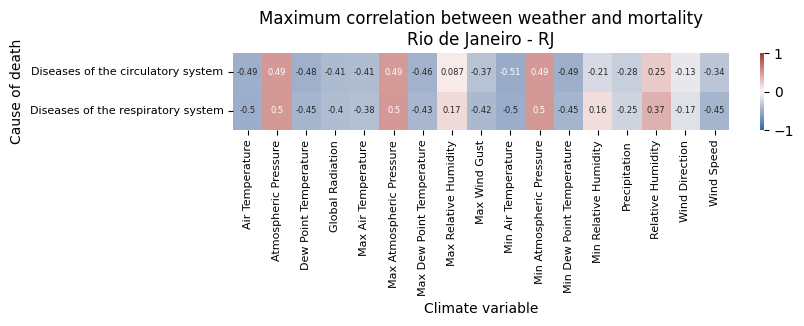

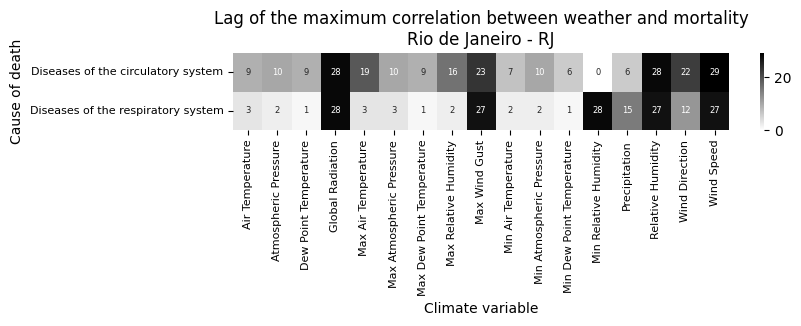

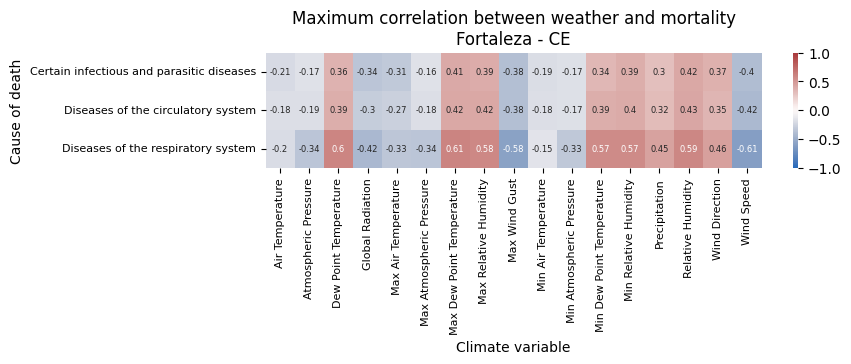

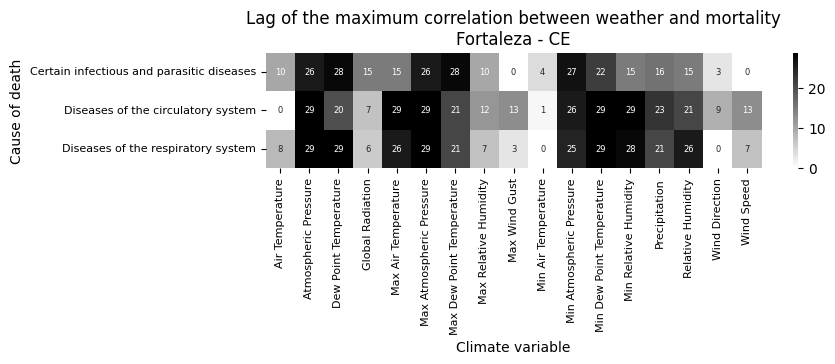

In [8]:
death_column = 'DEATHS_STANDARDIZED_BR'
weather_variables = ['air_temperature', 'atmospheric_pressure', 'dew_point_temperature',
                     'global_radiation', 'max_air_temperature', 'max_atmospheric_pressure',
                     'max_dew_point_temperature', 'max_relative_humidity', 'max_wind_gust',
                     'min_air_temperature', 'min_atmospheric_pressure',
                     'min_dew_point_temperature', 'min_relative_humidity', 'precipitation',
                     'relative_humidity', 'wind_direction', 'wind_speed']
weather_names = [x.replace('_', ' ').title() for x in weather_variables]
weather_dict = {x:y for (x,y) in zip(weather_variables, weather_names)}
weather_aggregation = {'air_temperature':'mean',
                       'atmospheric_pressure':'mean',
                       'dew_point_temperature':'mean',
                       'global_radiation':'mean',
                       'max_air_temperature':'max',
                       'max_atmospheric_pressure':'max',
                       'max_dew_point_temperature':'max',
                       'max_relative_humidity':'max',
                       'max_wind_gust':'max',
                       'min_air_temperature':'min',
                       'min_atmospheric_pressure':'min',
                       'min_dew_point_temperature':'min',
                       'min_relative_humidity':'min',
                       'precipitation':'mean',
                       'relative_humidity':'mean',
                       'wind_direction':'mean',
                       'wind_speed':'mean'}

corr_cv = 0.3
for state, i in zip(['SP', 'RJ', 'CE'], range(9)):

  # Get climate data
  climate_data = climate_df.reset_index().set_index('time')
  climate_data = climate_data[[(state, x) for x in weather_variables]]
  climate_data.index = pd.to_datetime(climate_data.index)
  climate_data.columns = climate_data.columns.get_level_values(1)
  climate_data = climate_data.resample('D').agg(weather_aggregation)

  # Get ICD-code group from ICD-code
  icd_dict_keys = list(icd_dict.keys())
  divide_codes = [x.split('-') for x in icd_dict_keys]
  def f(x):
    for i in range(len(divide_codes)):
      if divide_codes[i][0]<=x<=divide_codes[i][1]:
        return icd_dict[icd_dict_keys[i]]

  # Get mortality data
  mortality_data = pd.read_csv(f'{path}sim/capitals_standardized/{state}_standardized_1996_2022.csv')
  mortality_data.DT = pd.to_datetime(mortality_data.DT)
  mortality_data = mortality_data[(mortality_data.DT.dt.year>=2013)&(mortality_data.DT.dt.year<=2018)]
  mortality_data.DT = mortality_data.DT.dt.strftime('%m-%d')
  mortality_data = mortality_data[mortality_data.DT!='02-29'] #remove february 29th
  mortality_data.DT = pd.to_datetime('2024-'+mortality_data.DT)
  mortality_data.CAUSE = mortality_data.CAUSE.apply(lambda x: f(x))
  mortality_data = mortality_data[mortality_data.CAUSE.isin(top_causes)]
  mortality_data = mortality_data[['DT', 'CAUSE', death_column]].groupby(['CAUSE', 'DT']).sum().reset_index()
  mortality_data = mortality_data.pivot(index='DT', columns='CAUSE', values=death_column)
  causes_of_death = [' '.join(x[:x.rfind(' ', 0, 60)].split()) + '...' if len(x) > 60 else x for x in mortality_data.columns]
  causes_of_death_dict = {x:y for (x, y) in zip(mortality_data.columns, causes_of_death)}
  causes_of_death_simplified = [' '.join(x[:x.rfind(' ', 0, 30)].split()) + '...' if len(x) > 30 else x for x in mortality_data.columns]
  causes_of_death_simplified_dict = {x:y for (x, y) in zip(mortality_data.columns, causes_of_death_simplified)}

  # Merge data
  data = mortality_data.merge(climate_data, left_index=True, right_index=True)
  data = data.rename(columns={death_column:'deaths'})

  # Calculate maximum correlation between cause of death and climate variable iterating all lags
  # Check lag-correlation profile for the most correlated climate variable and its respective lag
  # for the causes with correlation at least above the set correlation critical value (corr_cv)
  n_lags = 30
  greater_corr = None
  data_corr = None
  for lag in range(0,n_lags):
    # lag the dataset
    data_lagged = data.copy()
    data_lagged[weather_variables] = np.roll(data_lagged[weather_variables], lag, axis=0)
    data_corr_i = data_lagged.corr(correlation_method).drop(columns=mortality_data.columns).loc[mortality_data.columns]#.round(2)
    # data_corr_i = data_corr_i[((data_corr_i.abs()>corr_cv)&(data_corr_i!=1)).any(axis=1)]

    # Get maximum correlation and its respective lag
    # Compare current lag correlation with the last one and update
    if data_corr is None:
      data_corr = data_corr_i.copy()
      data_lag = pd.DataFrame(0, columns=data_corr.columns, index=data_corr.index)
    else:
      data_corr = pd.DataFrame(np.where(abs(data_corr)>abs(data_corr_i), data_corr, data_corr_i),
                               columns=data_corr.columns, index=data_corr.index)
      data_lag = pd.DataFrame(np.where(abs(data_corr)>abs(data_corr_i), data_lag, lag),
                              columns=data_corr.columns, index=data_corr.index)

  # Plot maximum correlation between mortality and weather
  data_corr = data_corr[((data_corr.abs()>corr_cv)&(data_corr!=1)).any(axis=1)]
  x_ticks = data_corr.columns.map(weather_dict)
  y_ticks = data_corr.index.map(causes_of_death_dict)
  fig, ax = plt.subplots(figsize=(min(0.5*len(x_ticks),8), min(0.5*len(y_ticks),6)))
  sns.heatmap(data_corr, annot=True, annot_kws={'size': 6},
              vmin=-1, vmax=1, cmap='vlag', ax=ax)
  ax.set_title(f"Maximum correlation between weather and mortality\n"
                  f"{capital_dict[state]}", fontsize=12)
  ax.set_xlabel('Climate variable', fontsize=10)
  ax.set_xticks(np.arange(0.5, len(x_ticks)), x_ticks, rotation=90, fontsize=8)
  ax.set_ylabel('Cause of death', fontsize=10)
  ax.set_yticks(np.arange(0.5, len(y_ticks)), y_ticks, fontsize=8)
  plt.show()

  # Plot lag of maximum correlation between weather and mortality
  data_lag = data_lag.loc[((data_corr.abs()>corr_cv)&(data_corr!=1)).any(axis=1).index,:]
  x_ticks = data_lag.columns.map(weather_dict)
  y_ticks = data_lag.index.map(causes_of_death_dict)
  fig, ax = plt.subplots(figsize=(min(0.5*len(x_ticks),8), min(0.5*len(y_ticks),6)))
  sns.heatmap(data_lag, annot=True, annot_kws={'size': 6},
              cmap='binary', ax=ax)
  ax.set_title(f"Lag of the maximum correlation between weather and mortality\n"
                  f"{capital_dict[state]}", fontsize=12)
  ax.set_xlabel('Climate variable', fontsize=10)
  ax.set_xticks(np.arange(0.5, len(x_ticks)), x_ticks, rotation=90, fontsize=8)
  ax.set_ylabel('Cause of death', fontsize=10)
  ax.set_yticks(np.arange(0.5, len(y_ticks)), y_ticks, fontsize=8)
  plt.show()

# Temperature vs Mortality

Knowing that Dew Point Temperature is the supreme weather measure associated with mortality, we investigate the relationship between Dew Point Temperature and mortality in the three cities. For that, we plot Dew Point Temperature x Mortality and model it with a cubic spline model. We see then that the cities have very different ranges and points of maximums and minimums. São Paulo has only a single peak at the middle of the series, Rio de Janeiro has both a peak and a trough, and Fortaleza has none, with the maximum and minimum values being at the extremes of the Dew Point Temperature range.

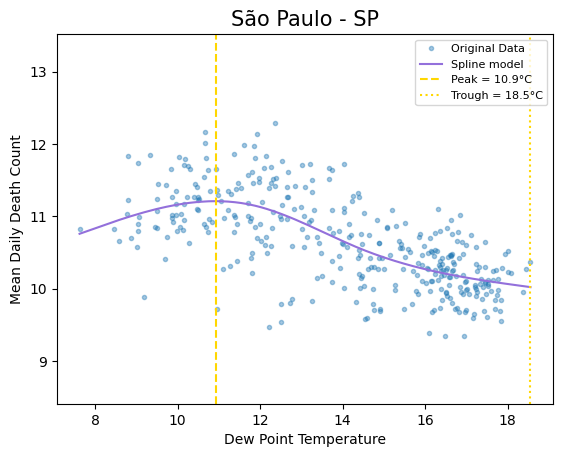

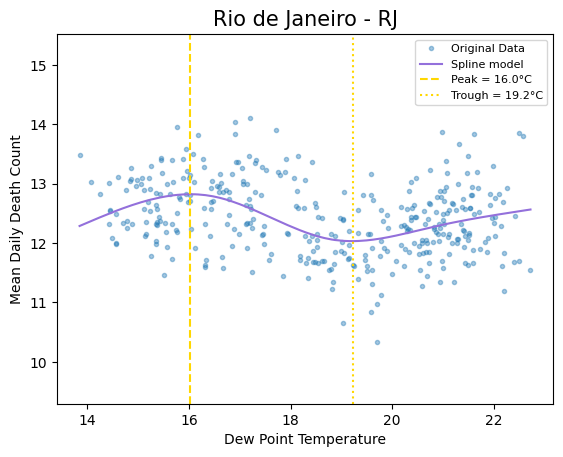

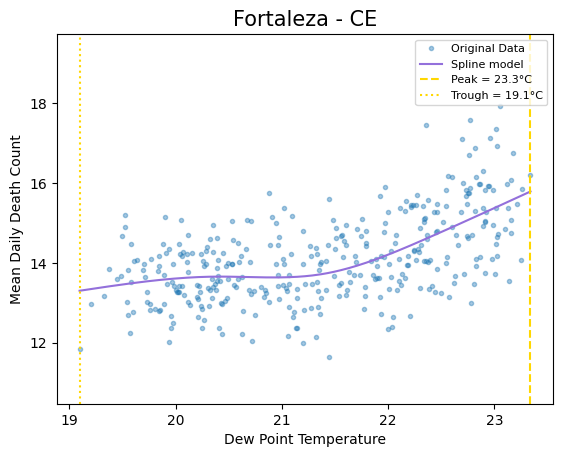

In [9]:
death_column = 'DEATHS_STANDARDIZED_BR'
first_year, last_year = 2013, 2018

import statsmodels.api as sm
results = []
# for state, i in zip(states[:n_capitals], np.arange(len(states[:n_capitals]))):
for state, i in zip(['SP', 'RJ', 'CE'], range(3)):

  # Mortality data
  mortality_data = pd.read_csv(f'{path}sim/capitals_standardized/{state}_standardized_1996_2022.csv')
  mortality_data.DT = pd.to_datetime(mortality_data.DT)
  mortality_data = mortality_data[(mortality_data.DT.dt.year>=2013)&(mortality_data.DT.dt.year<=2018)]
  mortality_data.DT = mortality_data.DT.dt.strftime('%m-%d')
  mortality_data = mortality_data[mortality_data.DT!='02-29'] #remove february 29th
  mortality_data.DT = pd.to_datetime('2024-'+mortality_data.DT)
  mortality_data = mortality_data[['DT', death_column]].groupby('DT').sum()

  def plot_state(weather_column, death_column, agg_function='mean', unit='°C'):

    fig, ax = plt.subplots(figsize=(6.4,4.8))

    # Climate data
    climate_data = climate_df.loc[:,climate_df.columns.get_level_values(0)==state]
    climate_data.columns = climate_data.columns.get_level_values(1)
    climate_data = climate_data[weather_column].reset_index()[['time', weather_column]].set_index('time')
    climate_data.index = pd.to_datetime(climate_data.index)
    climate_data = climate_data.resample('D').agg(agg_function)
    climate_data = climate_data[climate_data.index!='2024-02-29'] #remove ferbuary 29th

    # Merge data
    data = mortality_data.merge(climate_data, left_index=True, right_index=True)

    # Create a natural cubic regression spline with 4 degrees of freedom
    formula = f"{death_column} ~ cr({weather_column}, df=4, constraints='center')"
    spl = sm.OLS.from_formula(formula, data=data)

    # Fit the model
    spline_model = spl.fit()

    # Get predictions
    prediction_column = f"predictions_{death_column}"
    data[prediction_column] = spline_model.predict(data)
    data = data.sort_values(by=weather_column, ascending=True)

    # Get turning points
    peak = data[data[prediction_column]==data[prediction_column].max()][weather_column].values[0]
    through = data[data[prediction_column]==data[prediction_column].min()][weather_column].values[0]

    # Plot curve
    ax.plot(data[weather_column], data[death_column], 'o', alpha=0.4, ms=3, label='Original Data')
    ax.plot(data[weather_column], data[prediction_column], '-', color='mediumpurple', label='Spline model')
    ax.set_title(capital_dict[state], fontsize=15)
    ax.set_xlabel(weather_column.replace('_', ' ').title(), fontsize=10)
    ax.set_ylabel('Mean Daily Death Count', fontsize=10)
    ax.set_ylim(data[death_column].min()*0.9, data[death_column].max()*1.1)

    # Plot turning point
    ax.axvline(x=peak, color='gold', ls='--', label=f'Peak = {peak.round(1)}{unit}')
    ax.axvline(x=through, color='gold', ls=':', label=f'Trough = {through.round(1)}{unit}')
    ax.legend(loc='upper right', fontsize=8)

    # Save results
    results.append({'state':state, 'weather_variable':weather_column, 'peak':peak, 'trough':through})

    # Show plot
    plt.show()

  plot_state('dew_point_temperature', death_column)
  # plot_state('min_air_temperature', death_column, 'min')

In [10]:
# Calculating percentage of HDDs in winter according to weather variables
results_df = pd.DataFrame(results)
results_df['percentage'] = np.nan
for row in range(len(results_df)):
  state = results_df.loc[row]['state']
  weather_variable = results_df.loc[row]['weather_variable']
  trough = results_df.loc[row]['trough']
  climate_data = climate_df.iloc[:,climate_df.columns.get_level_values(0)==state]
  climate_data = climate_data.iloc[:,climate_data.columns.get_level_values(1)==weather_variable]
  climate_data = climate_data[climate_data<trough]
  winter = climate_data[climate_data.index.get_level_values(0).str[5:7].isin(['06','07','08','09'])]
  hdd_winter = (trough-winter).sum()
  other = climate_data[~climate_data.index.get_level_values(0).str[5:7].isin(['06','07','08','09'])]
  hdd_other = (trough-other).sum()
  percentage = (100*hdd_winter/(hdd_winter+hdd_other)).item()
  results_df.at[row, 'percentage'] = percentage
results_df

,state,weather_variable,peak,trough,percentage
0,SP,dew_point_temperature,10.929167,18.549306,55.740641
1,RJ,dew_point_temperature,16.030417,19.228472,78.347101
2,CE,dew_point_temperature,23.339444,19.096528,86.886127


In [11]:
# Calculating percentage of HDDs in winter according to weather variables
results_df = pd.DataFrame(results)
results_df['percentage'] = np.nan
for row in range(len(results_df)):
  state = results_df.loc[row]['state']
  weather_variable = results_df.loc[row]['weather_variable']
  trough = results_df.loc[row]['trough']
  climate_data = climate_df.iloc[:,climate_df.columns.get_level_values(0)==state]
  climate_data = climate_data.iloc[:,climate_data.columns.get_level_values(1)==weather_variable]
  climate_data = climate_data[climate_data<trough]
  winter = climate_data[climate_data.index.get_level_values(0).str[5:7].isin(['06','07','08','09'])]
  hdd_winter = (trough-winter).sum()
  other = climate_data[~climate_data.index.get_level_values(0).str[5:7].isin(['06','07','08','09'])]
  hdd_other = (trough-other).sum()
  percentage = (100*hdd_winter/(hdd_winter+hdd_other)).item()
  results_df.at[row, 'percentage'] = percentage
results_df

,state,weather_variable,peak,trough,percentage
0,SP,dew_point_temperature,10.929167,18.549306,55.740641
1,RJ,dew_point_temperature,16.030417,19.228472,78.347101
2,CE,dew_point_temperature,23.339444,19.096528,86.886127


# Predicting seasonality with climate

We started another investigation of the relationship between climate and mortality but with a different methodology. Our goal was to predict the seasonality of a state capital using the city's climate indicators. Those climate indicators were yearly aggregates of the weather variables. Therefore, we predict the seasonality (measured by the EDi) with the weather variables aggregates (mean and std). We used a Ridge Regression Model and Recursive Feature Elimination to select the most critical variables, starting with a single variable, up to 20.

The prediction is better as the variables increase to 10, reaching a plateau after that, likely due to the curse of dimensionality. The model is also strange at first glance since some weather variables we did not expect appear to be important, such as wind direction. We hypothesize that those are indirectly related to another variable, maybe because of the distribution of wind directions across the country or the year's seasons. In conclusion, we would need to invest more into this analysis, maybe adding more possibilities or variables or considering alternative ways of aggregating or using the whole time series to predict the seasonality.

In [12]:
## DATA PROCESSING

# Time frame and mortality variable
death_column = 'DEATHS_STANDARDIZED_BR'
first_year, last_year = 2013, 2018

# Seasonality data
edi = pd.read_csv(f"{path}/measures/edi_1_by_state.csv")
edi = edi[['state', 'edi']]

n_capitals = len(capital_dict)
df = None
for state, i in zip(states[:n_capitals], np.arange(len(states[:n_capitals]))):

  # Mortality data
  mortality_data = pd.read_csv(f'{path}sim/capitals_standardized/{state}_standardized_1996_2022.csv')
  mortality_data.DT = pd.to_datetime(mortality_data.DT)
  mortality_data = mortality_data[(mortality_data.DT.dt.year>=2013)&(mortality_data.DT.dt.year<=2018)]
  mortality_data.DT = mortality_data.DT.dt.strftime('%m-%d')
  mortality_data = mortality_data[mortality_data.DT!='02-29'] #remove february 29th
  mortality_data.DT = pd.to_datetime('2024-'+mortality_data.DT)
  mortality_data = mortality_data[['DT', death_column]].groupby('DT').sum().reset_index()
  mortality_data['DT_right'] = mortality_data.DT.dt.strftime('%m-%d')
  dic = {mortality_data.DT_right.unique()[i]: i for i in np.arange(len(mortality_data.DT_right.unique()))}
  mortality_data['DT_numeric'] = mortality_data.DT_right.apply(lambda x: dic[x])

  ## Calculating EDi
  n = 120 # I'm using n to analyse the period of 4 months as in EWDi (365/x = n)
  # Create array linking yearly death counts in a cycle (0-364, 364-728)
  array = mortality_data[death_column]
  array = pd.concat([array, array], ignore_index=True)
  # Find interval of n days in which there are more deaths
  # Using Kadane's algorithm
  len_array = len(array)
  current_sum = 0
  end_index = n-1
  # Calculate first window
  for i in range(n):
    current_sum += array[i]
  max_sum = current_sum
  end_index = n
  # Calculate following windows
  for i in range(n, int(len_array/2+n)):
    current_sum = current_sum + array[i] - array[i-n]
    if current_sum>max_sum:
      max_sum = current_sum
      end_index = i
  # Get the period
  start_day = end_index - n
  if end_index>=365: end_day = end_index-365
  else: end_day = end_index
  start_date = mortality_data[mortality_data.DT_numeric==start_day]['DT_right'].values[0]
  end_date = mortality_data[mortality_data.DT_numeric==end_day]['DT_right'].values[0]
  # Get stats
  avg_value = mortality_data[death_column].mean()
  # Excess Death index (deaths in the n weeks with more deaths versus rest of the year )
  # for expected deaths, we take the proportion between the n_days of greatest and n_days of the rest
  expected_deaths = (mortality_data[death_column].sum() - max_sum)*(n/(365-n))
  greatest_deaths = max_sum
  edi = (greatest_deaths - expected_deaths)/expected_deaths

  # ## Calculating PTR
  # # Create a cyclical spline with 4 degrees of freedom
  # formula = f"{death_column} ~ cc(DT_numeric, df=4, constraints='center')"
  # spl = sm.OLS.from_formula(formula, data=mortality_data)

  # # Fit the model
  # spline_model = spl.fit()

  # # Get predictions
  # predictions = spline_model.predict(mortality_data) #needs a variable called DT_numeric to predict
  # mortality_data['predictions'] = predictions

  # # Calculate stats
  # max_value = mortality_data[mortality_data['predictions']==mortality_data['predictions'].max()]
  # min_value = mortality_data[mortality_data['predictions']==mortality_data['predictions'].min()]
  # avg_value = mortality_data.predictions.mean()
  # mortality_data['relative_risk'] = mortality_data['predictions'] / avg_value
  # peak_day = max_value.DT_numeric.values[0]
  # trough_day = min_value.DT_numeric.values[0]
  # peak_date = max_value.DT_right.values[0]
  # trough_date = min_value.DT_right.values[0]
  # peak_deaths = max_value['predictions'].values[0]
  # trough_deaths = min_value['predictions'].values[0]
  # ptr = peak_deaths/trough_deaths


  # Climate data
  climate_data = climate_df.loc[:,climate_df.columns.get_level_values(0)==state]
  climate_data.columns = climate_data.columns.get_level_values(1)
  variables = ['air_temperature', 'atmospheric_pressure', 'dew_point_temperature',
             'global_radiation', 'relative_humidity', 'precipitation',
             'max_wind_gust', 'wind_speed', 'wind_direction']
  climate_data = climate_data[variables]
  climate_data = climate_data.reset_index().set_index('time').drop(columns=['level_1'])
  climate_data.index = pd.to_datetime(climate_data.index)
  # climate_data.resample('D').agg(weather_aggregation)
  # climate_data = climate_data.resample('D').agg(weather_aggregation)
  climate_data = climate_data[climate_data.index!='2024-02-29'] #remove february 29th

  ## Get climate data summaries
  # climate_summary = climate_data.agg(['mean', 'median', 'std', lambda x:x.quantile(0.2), lambda x: x.quantile(0.8)])
  # climate_summary.index = ['mean', 'median', 'std', '20th_percentile', '80th_percentile']
  # climate_summary = climate_data.agg(['mean', 'median', 'std'])
  # climate_summary.index = ['mean', 'median', 'std']
  climate_summary = climate_data.agg(['mean', 'std'])
  climate_summary.index = ['mean', 'std']
  climate_summary = climate_summary.stack()
  climate_summary.index = ['_'.join([str(i) for i in reversed(idx)]) for idx in climate_summary.index]
  climate_summary = climate_summary.sort_index()
  climate_summary = pd.DataFrame(climate_summary).T
  climate_summary['state'] = state
  # climate_summary['city'] = capital_dict[state]

  # Add edi to dataset
  climate_summary['edi'] = edi
  # climate_summary['ptr'] = ptr
  # Join states datasets
  if df is None:
    df = climate_summary
  else:
    df = pd.concat([df, climate_summary], ignore_index=True)

1 feature(s)
MAPE = 0.3727811429682783


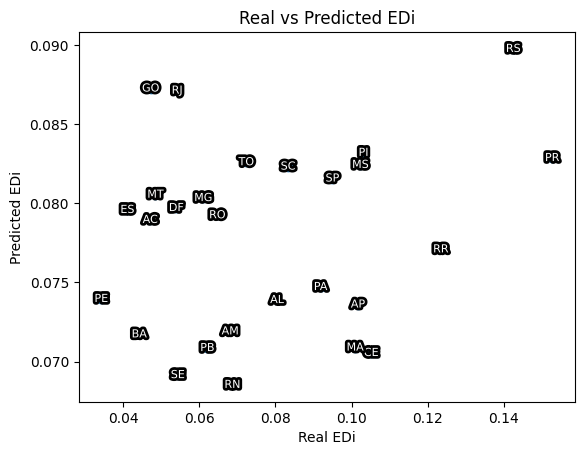

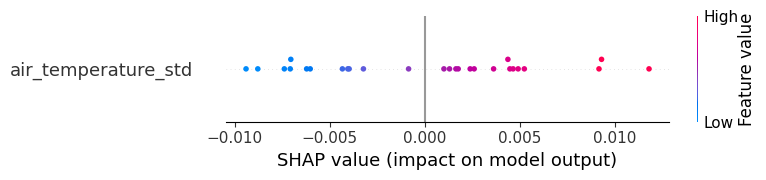

2 feature(s)
MAPE = 0.3634693475855389


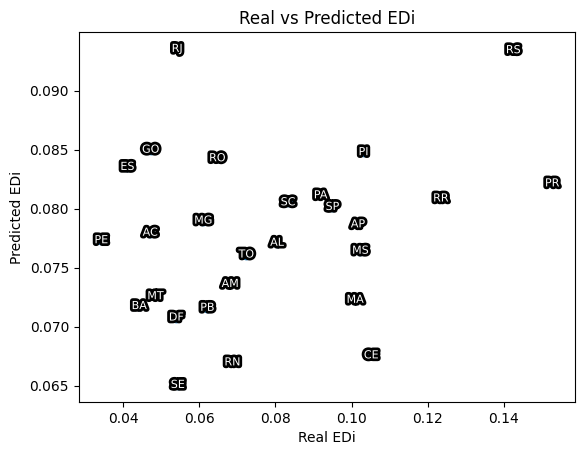

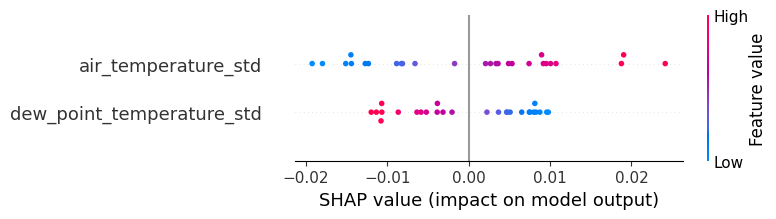

3 feature(s)
MAPE = 0.33991471600507156


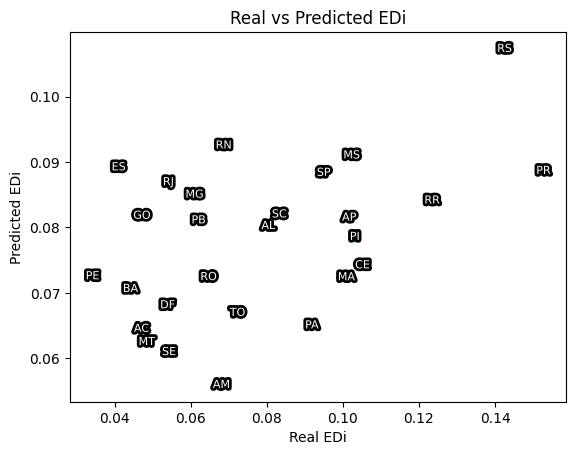

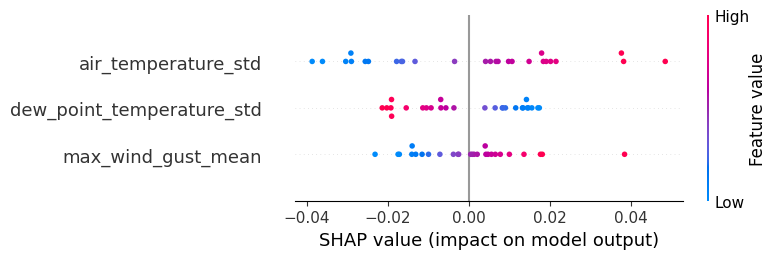

4 feature(s)
MAPE = 0.29441398065483965


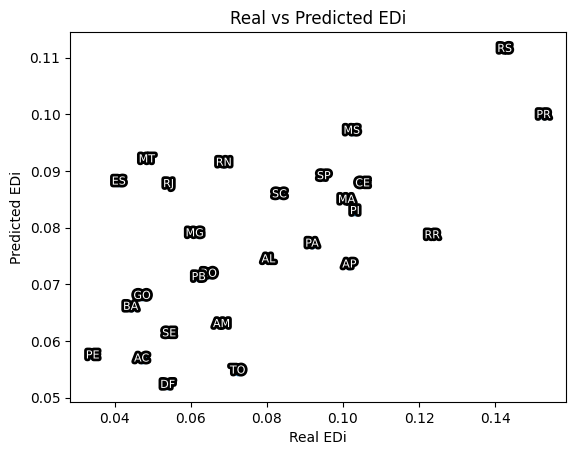

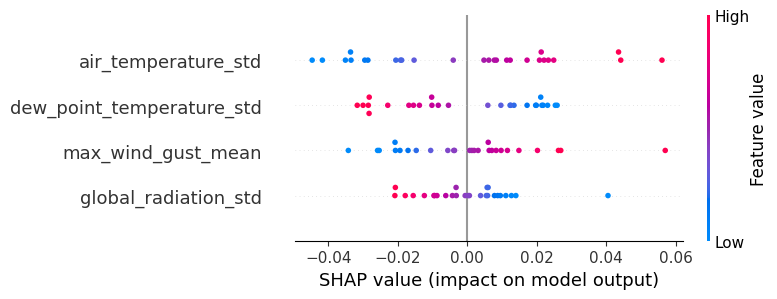

6 feature(s)
MAPE = 0.21056239659971665


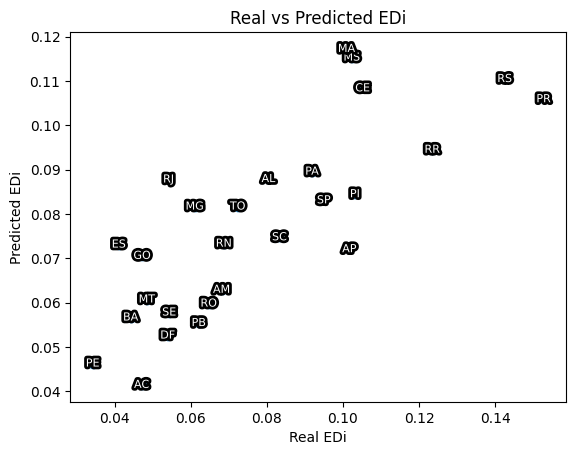

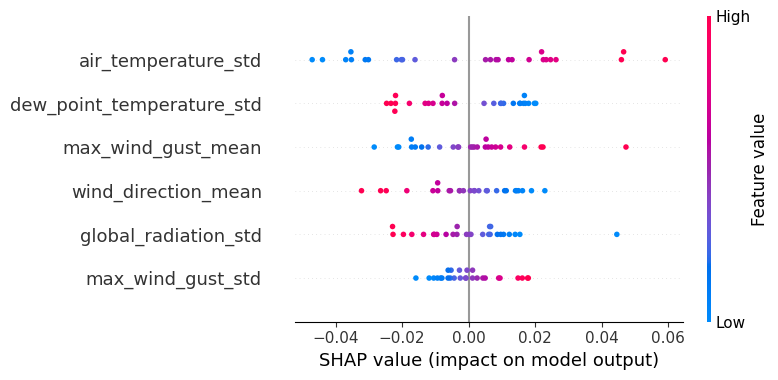

8 feature(s)
MAPE = 0.2044966735850241


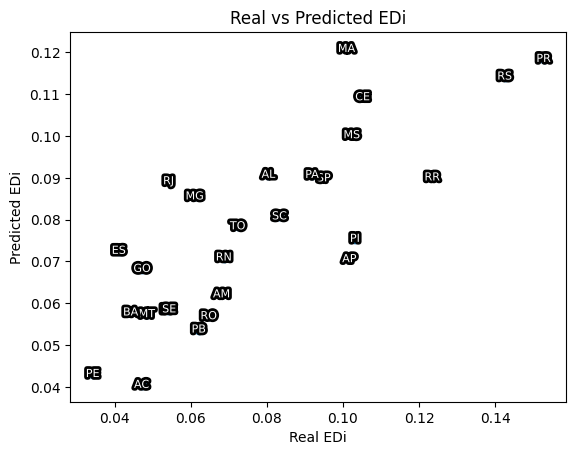

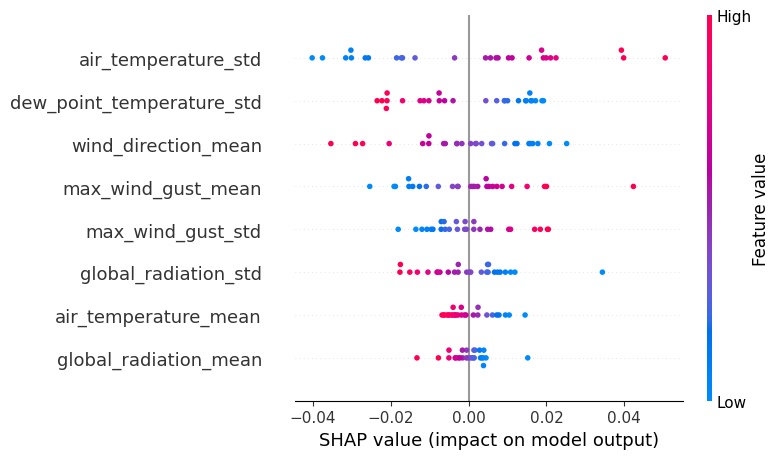

10 feature(s)
MAPE = 0.18470995582094998


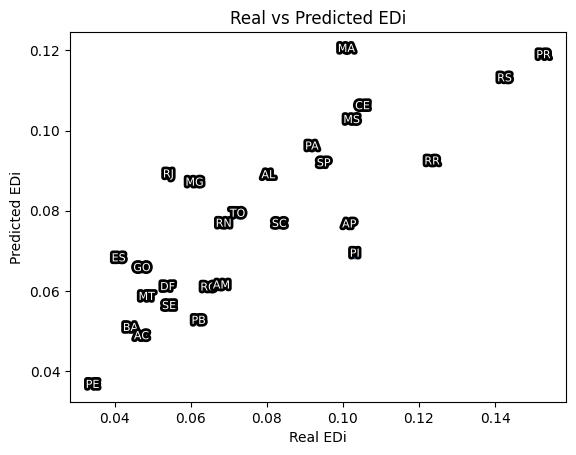

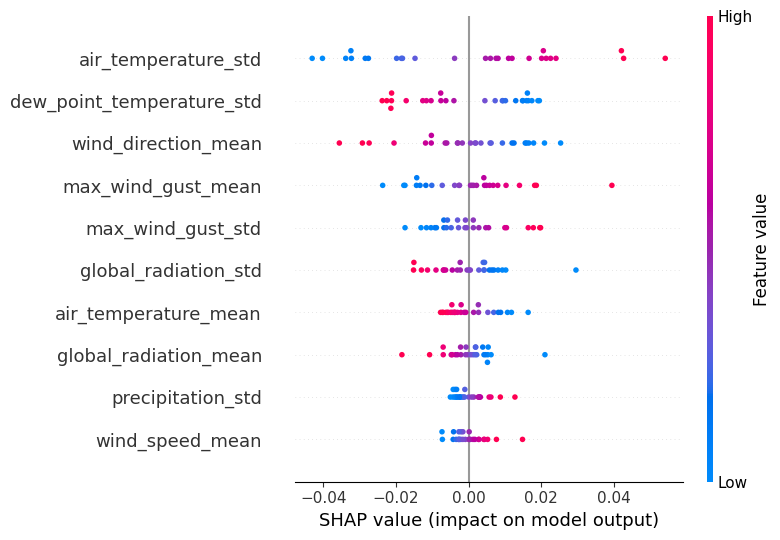

15 feature(s)
MAPE = 0.18931353554877306


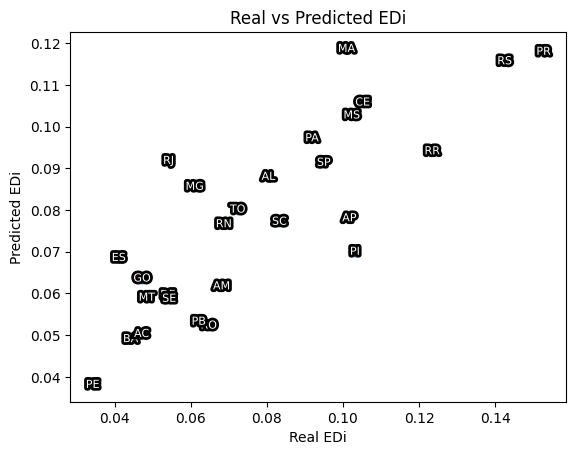

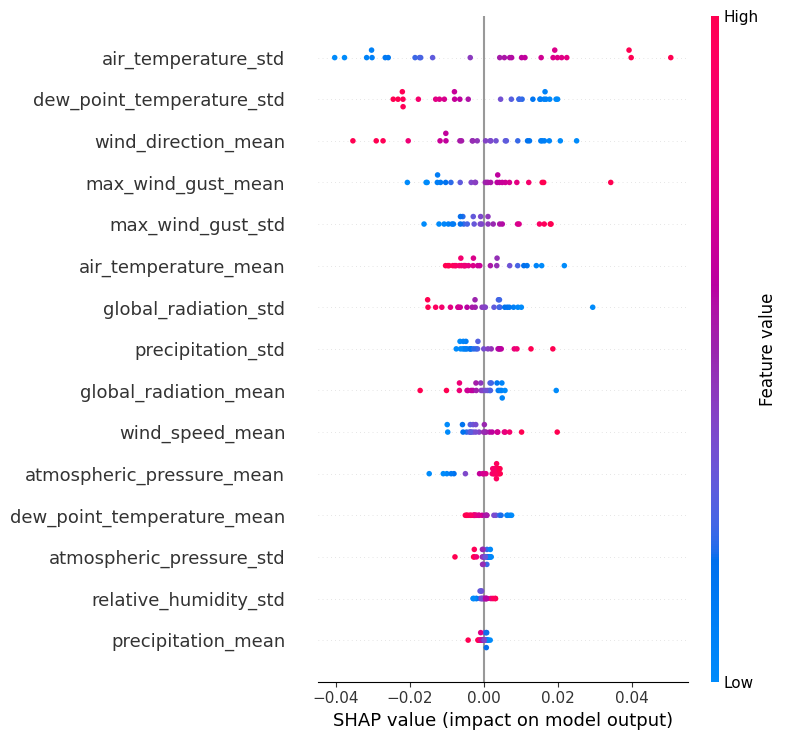

20 feature(s)
MAPE = 0.1878135108707123


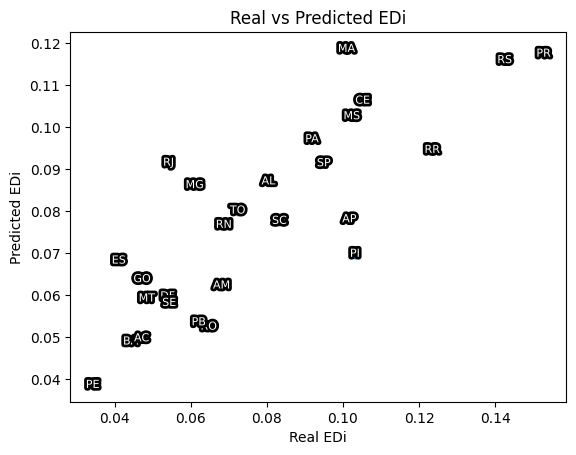

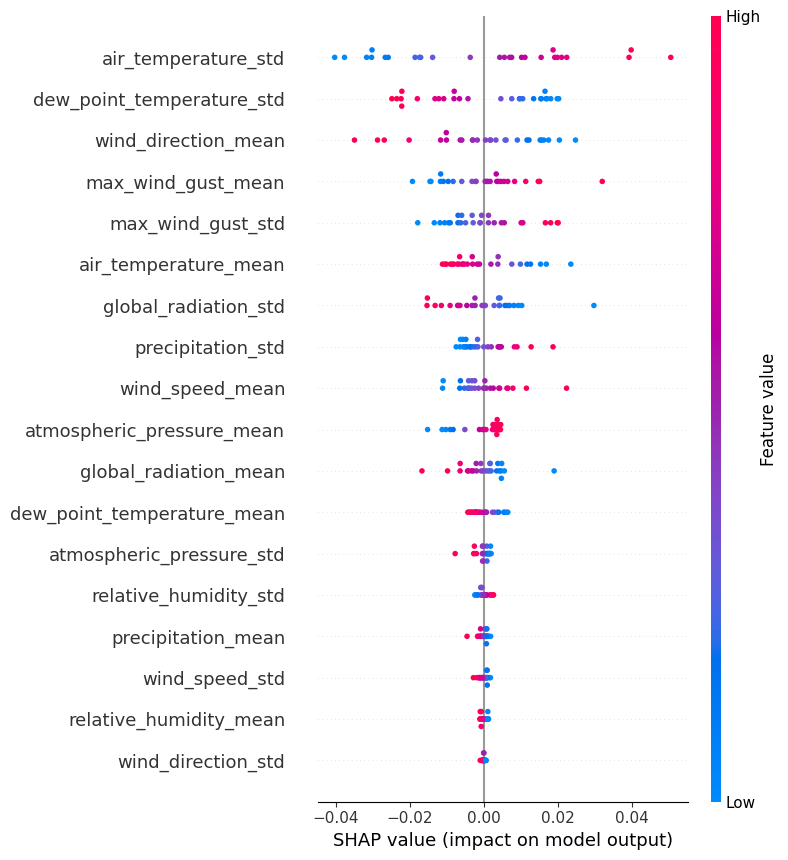

In [13]:
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
import shap
from matplotlib.patheffects import withStroke

# Data processing
X, y, state = df.drop(['edi', 'state'], axis=1), df['edi'], df['state']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

mapes = [] #store MAPEs
n_variables = [1, 2, 3, 4, 6, 8, 10, 15, 20]
for i in n_variables:

  # Define model
  model = Ridge()

  print(BOLD+f"{i} feature(s)"+END)
  # Feature selector (Recursive Feature Elimination)
  selector = RFE(estimator=model, n_features_to_select=i)
  selector = selector.fit(X_scaled, y)
  selected_features = X_scaled.columns[selector.support_]

  # Modelling
  model.fit(X_scaled[selected_features], y)
  y_pred = model.predict(X_scaled[selected_features])
  mape = mean_absolute_percentage_error(y, y_pred)
  print(f'MAPE = {mape}')
  mapes.append(mape)

  # Show modelling results
  plt.scatter(y, y_pred)
  plt.xlabel('Real EDi')
  plt.ylabel('Predicted EDi')
  plt.title('Real vs Predicted EDi')
  for real, pred, label in zip(y, y_pred, state):
    plt.text(real, pred, label, fontsize=8, ha='center', va='center',
             color='white',
             path_effects=[withStroke(linewidth=4, foreground="black")])
  plt.show()

  # # Coefficients
  # coefficients = pd.DataFrame(model.coef_, selected_features, columns=['Coefficient'])
  # display(coefficients.sort_values(by='Coefficient', key=abs, ascending=False))

  # SHAP Feature explainer
  explainer = shap.Explainer(model, X_scaled[selected_features])
  shap_values = explainer(X_scaled[selected_features])
  shap.summary_plot(shap_values, feature_names=selected_features)

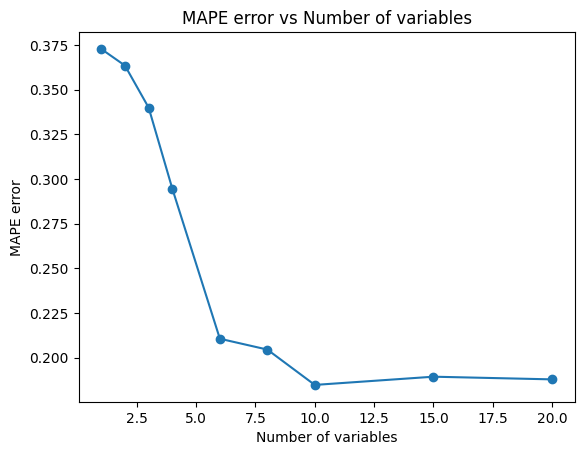

In [14]:
plt.plot(n_variables, mapes)
plt.scatter(n_variables, mapes)
plt.title('MAPE error vs Number of variables')
plt.ylabel('MAPE error')
plt.xlabel('Number of variables')
plt.show()